In [19]:
from calibration_tools import * 

### I. Preprocessing

In [28]:
df = pd.read_csv('spx_options_2017_05_19.csv', sep=',')
SPX = prepare_raw_data_SPX(df)

df = pd.read_csv('vix_options_2017_05_19.csv', sep=',')
VIX = prepare_raw_data_VIX(df)

In [30]:
expiration_dates, variance_swap_mid, _, _ = variance_swap(SPX)
w = variance_swap_mid * expiration_dates 
xi_curve, _, w_smooth = smooth_curve(expiration_dates, w, xi=True, eps=0.01)

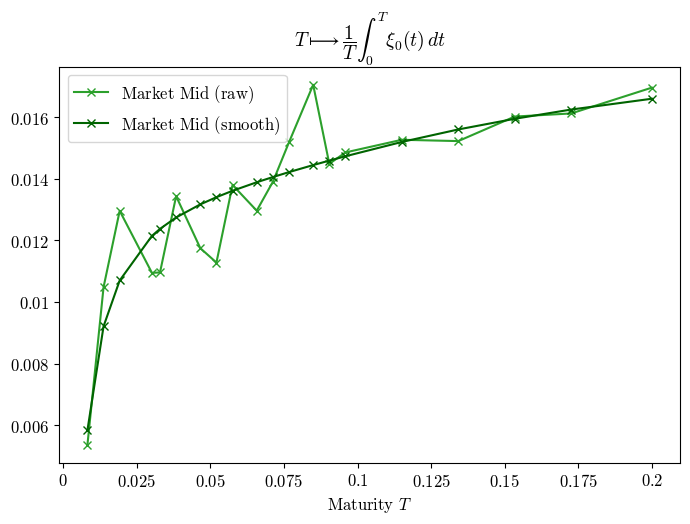

In [38]:
fig, ax = plt.subplots(figsize=(7,5.35))

ax.plot(expiration_dates, variance_swap_mid, "x-", color="tab:green", label=r"$\text{Market Mid (raw)}$")
ax.plot(expiration_dates, w_smooth/expiration_dates, "x-", color="darkgreen", label=r"$\text{Market Mid (smooth)}$")

ax.set_title(r"$T\longmapsto \dfrac{1}{T}\int_0^T \xi_0(t)\, dt$", fontsize=14)
ax.set_xlabel(r"$\text{Maturity }T$", fontsize=12)

ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

### II. Calibration

In [46]:
maturities = [12, 19, 26]

M = 10000
n_steps_per_day = 10 

n = maturities[-1] * n_steps_per_day
Y = simulate_antithetic(M, n) 
N = 200
N_quad = 50

gl_values = compute_gl_values(maturities, N_quad)
weights, y = load_quantization_gaussian(f"dim_1/{N}_1_nopti.txt")
y = y.ravel()
y_mm = moment_matching_gaussian_1D(weights, y, q=4)

In [48]:
bounds_params = np.array([
    (-1, -0.5),      # rho
    (-0.1, 0.1),     # H
    (0, 1),          # alpha_0 
    (0, 1),          # alpha_1
    (0, 1),          # alpha_3 
    (0, 0.2),        # alpha_5 
])

bounds_integrals = np.array([(0.7 * val, 1.3 * val) for val in w])
bounds = np.concatenate([bounds_params, bounds_integrals])

In [50]:
strikes_SPX, ivs_market_SPX, _, _, forwards_SPX, strikes_VIX, ivs_market_VIX, _, _, forwards_VIX = stripping_arrays(maturities, SPX, VIX)

In [43]:
maxiter = 25
popsize = 12

In [44]:
result_DE, result_NM, results_NM = genuine_calibration_procedure_exp(maxiter, popsize, bounds, strikes_SPX, ivs_market_SPX, forwards_SPX, 
                          strikes_VIX, ivs_market_VIX, forwards_VIX, 
                          M, Y, n_steps_per_day, maturities, gl_values, weights, y_mm, expiration_dates, 
                          polish=True, polish_DE=False, verbose=True, nm_starts=2)

____________________________________________________________

Step 1: Differential Evolution
____________________________________________________________

Approximately 8112 evaluations (if polish_DE=False).

[Iter 130] | SPX: NMSE=2.652957e-02
[Iter 130] | VIX: NMSE=4.980892e-01
[Iter 130] | Futures: NMSE=1.914429e-02
[Iter 130] | Loss: NMSE=1.467496e+00
[Iter 140] | SPX: NMSE=1.748468e-01
[Iter 140] | VIX: NMSE=4.144169e-01
[Iter 140] | Futures: NMSE=8.993660e-03
[Iter 140] | Loss: NMSE=1.591530e+00
[Iter 150] | SPX: NMSE=4.102735e-02
[Iter 150] | VIX: NMSE=4.584643e-01
[Iter 150] | Futures: NMSE=1.443222e-02
[Iter 150] | Loss: NMSE=1.342331e+00
[Iter 160] | SPX: NMSE=3.905912e-02
[Iter 160] | VIX: NMSE=1.311717e-01
[Iter 160] | Futures: NMSE=4.127967e-02
[Iter 160] | Loss: NMSE=1.218134e+00
[Iter 170] | SPX: NMSE=3.912320e-02
[Iter 170] | VIX: NMSE=1.303848e-01
[Iter 170] | Futures: NMSE=6.189431e-03
[Iter 170] | Loss: NMSE=5.149688e-01
[Iter 180] | SPX: NMSE=4.322998e-02
[Iter 180]

In [45]:
result_DE.x

array([-7.37369913e-01, -6.71779605e-02,  3.60536104e-01,  9.64855782e-01,
        5.85036022e-01,  1.89411196e-03,  5.06638552e-05,  1.77177303e-04,
        2.59855334e-04,  3.06044069e-04,  3.92705158e-04,  4.61085506e-04,
        5.85702843e-04,  5.62847052e-04,  7.56496242e-04,  6.81410506e-04,
        7.52289795e-04,  1.21164584e-03,  1.33809025e-03,  1.21631229e-03,
        1.45263318e-03,  1.36876948e-03,  2.30748635e-03,  2.12091669e-03,
        3.14411261e-03,  3.93738051e-03])

In [46]:
result_NM.x

array([-7.71856443e-01, -6.74755488e-02,  3.58647430e-01,  9.94373623e-01,
        5.89026286e-01,  1.86623675e-03,  5.04993837e-05,  1.69472225e-04,
        2.50061266e-04,  3.07382161e-04,  3.92513528e-04,  4.60623054e-04,
        5.94177952e-04,  5.73091822e-04,  7.49457318e-04,  6.89331531e-04,
        7.66353581e-04,  1.23192718e-03,  1.31512688e-03,  1.21111983e-03,
        1.45524430e-03,  1.39775399e-03,  2.27165208e-03,  2.11025444e-03,
        3.19348869e-03,  3.91505744e-03])

In [52]:
M = 100000
n_steps_per_day = 50 

n = maturities[-1] * n_steps_per_day
Y = simulate_antithetic(M, n) 

In [78]:
import pybobyqa

bounds_lower = [bounds[i][0] for i in range(len(bounds))]
bounds_upper = [bounds[i][1] for i in range(len(bounds))]

result_PY = pybobyqa.solve(
    genuine_to_minimize_exp,
    args=(strikes_SPX, ivs_market_SPX, forwards_SPX, 
                strikes_VIX, ivs_market_VIX, forwards_VIX, 
                M, Y, n_steps_per_day, maturities, gl_values, weights, y_mm, expiration_dates, 100, 
                True, [0]),
    bounds=(bounds_lower, bounds_upper),
    x0=result_DE.x,
    rhobeg=0.1,
    rhoend=1e-6,
    maxfun=1000,
    scaling_within_bounds=True
)

[Iter 10] | SPX: NMSE=9.767711e-03
[Iter 10] | VIX: NMSE=2.586028e-03
[Iter 10] | Futures: NMSE=3.112651e-04
[Iter 10] | Loss: NMSE=4.395639e-02
[Iter 20] | SPX: NMSE=7.686552e-03
[Iter 20] | VIX: NMSE=2.074503e-03
[Iter 20] | Futures: NMSE=2.163276e-04
[Iter 20] | Loss: NMSE=3.409740e-02
[Iter 30] | SPX: NMSE=7.466857e-03
[Iter 30] | VIX: NMSE=2.578253e-03
[Iter 30] | Futures: NMSE=2.121549e-04
[Iter 30] | Loss: NMSE=3.428913e-02
[Iter 40] | SPX: NMSE=7.739212e-03
[Iter 40] | VIX: NMSE=2.611491e-03
[Iter 40] | Futures: NMSE=2.117990e-04
[Iter 40] | Loss: NMSE=3.525633e-02
[Iter 50] | SPX: NMSE=7.750427e-03
[Iter 50] | VIX: NMSE=2.344232e-03
[Iter 50] | Futures: NMSE=1.936489e-04
[Iter 50] | Loss: NMSE=3.439620e-02
[Iter 60] | SPX: NMSE=6.389424e-03
[Iter 60] | VIX: NMSE=2.755294e-03
[Iter 60] | Futures: NMSE=7.647017e-05
[Iter 60] | Loss: NMSE=2.833807e-02
[Iter 70] | SPX: NMSE=5.759582e-03
[Iter 70] | VIX: NMSE=2.522820e-03
[Iter 70] | Futures: NMSE=5.453360e-05
[Iter 70] | Loss: NMS

In [83]:
result_PY.x

array([-7.57529238e-01, -5.40443200e-02,  3.61676215e-01,  1.00000000e+00,
        5.31011295e-01,  0.00000000e+00,  5.29878198e-05,  1.61468311e-04,
        2.38934267e-04,  2.96589820e-04,  3.92134799e-04,  4.70895720e-04,
        5.53111396e-04,  5.78248107e-04,  7.60459228e-04,  7.25506197e-04,
        8.16092871e-04,  1.28745301e-03,  1.31631583e-03,  1.22526969e-03,
        1.50868343e-03,  1.42648986e-03,  2.29270282e-03,  2.08157220e-03,
        3.00467279e-03,  4.00658152e-03])

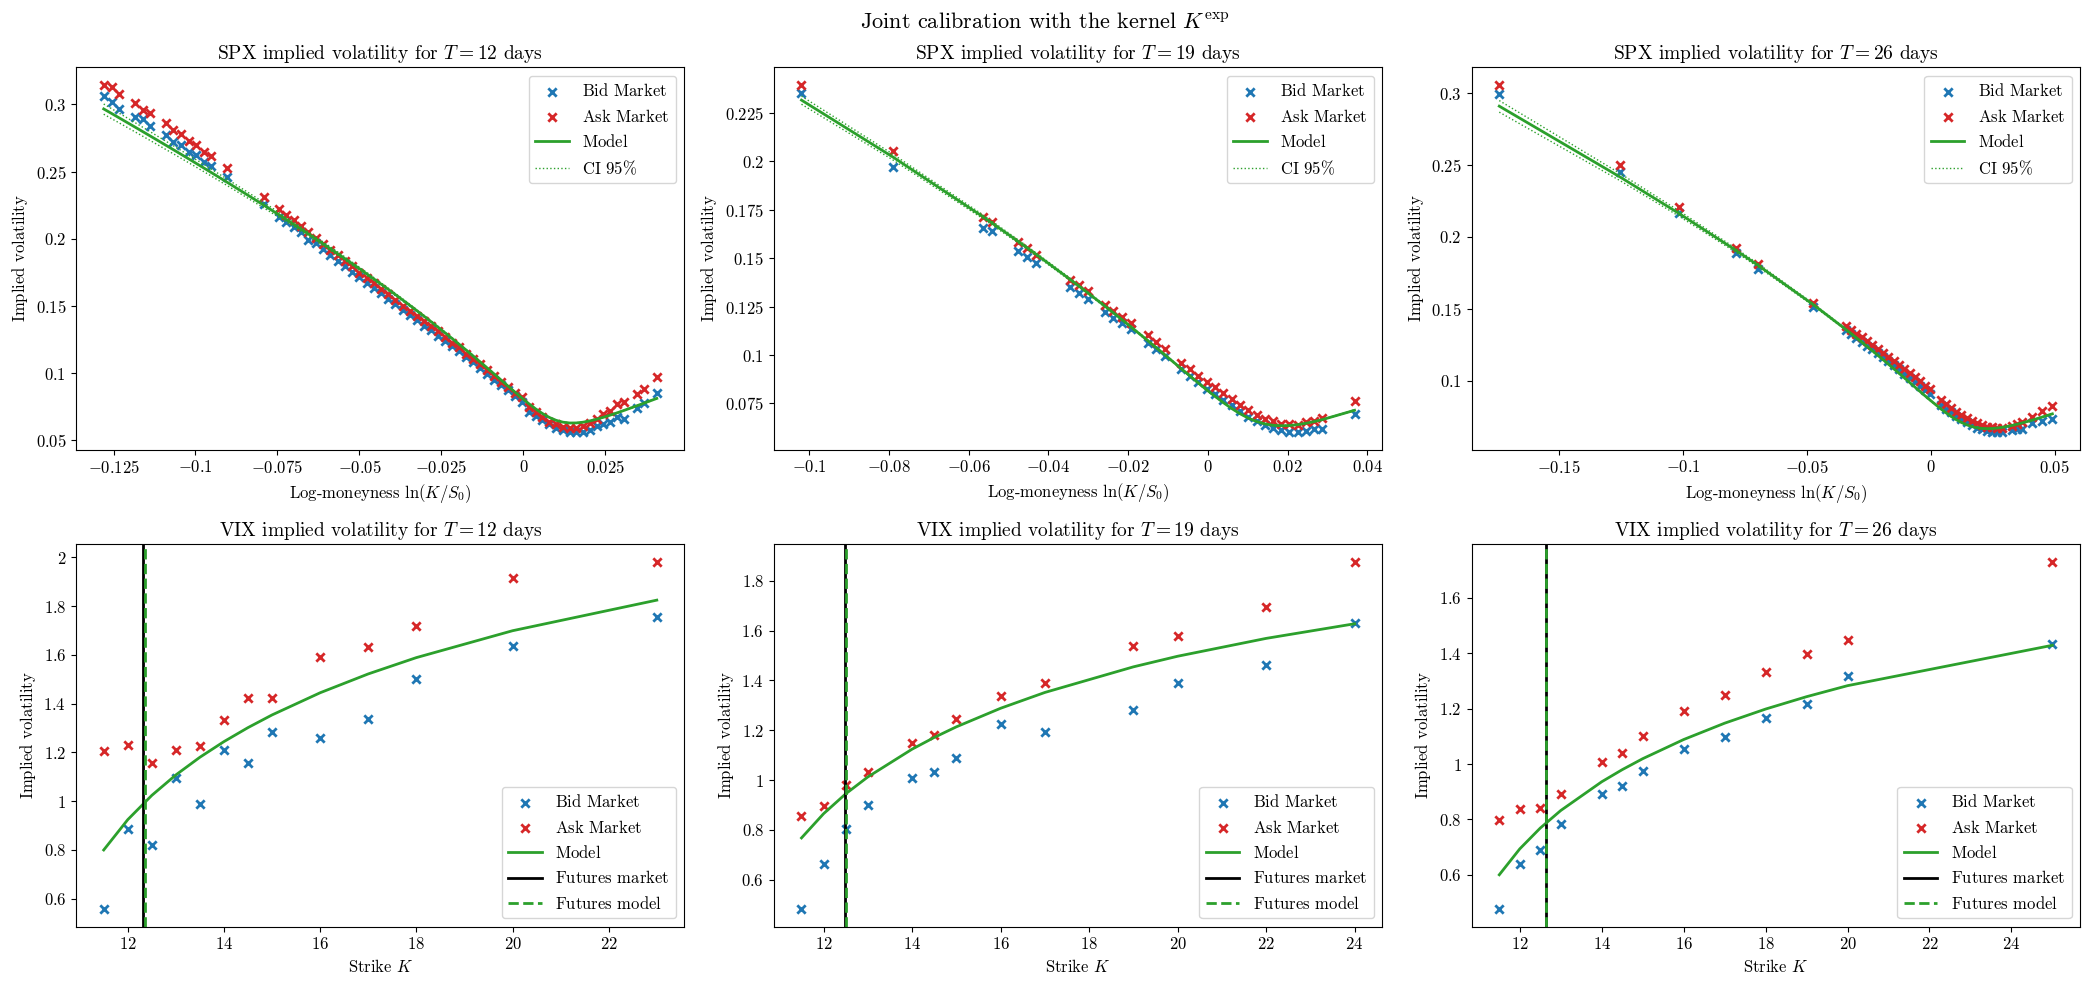

In [54]:
plot_IV_genuine_exp(result_PY, maturities, Y, SPX, VIX, N_quad, gl_values, weights, y_mm, expiration_dates) 

In [110]:
expiration_dates, variance_swap_mid, _, _ = variance_swap(SPX)
w = variance_swap_mid * expiration_dates 

w_DE = np.array([5.06638552e-05,  1.77177303e-04, 2.59855334e-04,  3.06044069e-04,  3.92705158e-04,  
              4.61085506e-04, 5.85702843e-04,  5.62847052e-04,  7.56496242e-04,  6.81410506e-04,
              7.52289795e-04,  1.21164584e-03,  1.33809025e-03,  1.21631229e-03,
              1.45263318e-03,  1.36876948e-03,  2.30748635e-03,  2.12091669e-03,
              3.14411261e-03,  3.93738051e-03])

w_NM = np.array([5.04993837e-05,  1.69472225e-04, 2.50061266e-04,  3.07382161e-04,  3.92513528e-04,  
                  4.60623054e-04, 5.94177952e-04,  5.73091822e-04,  7.49457318e-04,  6.89331531e-04,
                  7.66353581e-04,  1.23192718e-03,  1.31512688e-03,  1.21111983e-03,
                  1.45524430e-03,  1.39775399e-03,  2.27165208e-03,  2.11025444e-03,
                  3.19348869e-03,  3.91505744e-03])

w_PY = np.array([5.29878198e-05,  1.61468311e-04, 2.38934267e-04,  2.96589820e-04,  3.92134799e-04,  
                 4.70895720e-04, 5.53111396e-04,  5.78248107e-04,  7.60459228e-04,  7.25506197e-04,
                 8.16092871e-04,  1.28745301e-03,  1.31631583e-03,  1.22526969e-03,
                 1.50868343e-03,  1.42648986e-03,  2.29270282e-03,  2.08157220e-03,
                 3.00467279e-03,  4.00658152e-03])

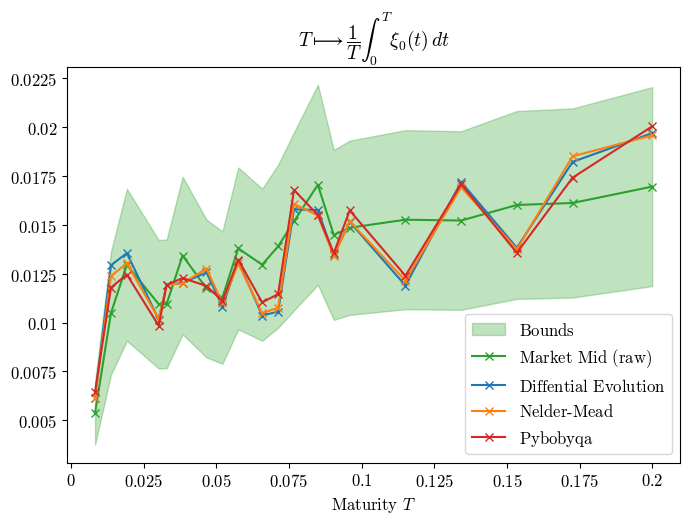

In [125]:
fig, ax = plt.subplots(figsize=(7, 5.35))
ax.fill_between(expiration_dates, w/expiration_dates * 0.7, w/expiration_dates * 1.3, color="tab:green", alpha=0.3, label=r"$\text{Bounds}$")
ax.plot(expiration_dates, w/expiration_dates, "x-", color="tab:green", label=r"$\text{Market Mid (raw)}$")
ax.plot(expiration_dates, w_DE/expiration_dates, "x-", color="tab:blue", label=r"$\text{Diffential Evolution}$")
ax.plot(expiration_dates, w_NM/expiration_dates, "x-", color="tab:orange", label=r"$\text{Nelder-Mead}$")
ax.plot(expiration_dates, w_PY/expiration_dates, "x-", color="tab:red", label=r"$\text{Pybobyqa}$")

ax.set_title(r"$T\longmapsto \dfrac{1}{T}\int_0^T \xi_0(t)\, dt$", fontsize=14)
ax.set_xlabel(r"$\text{Maturity }T$", fontsize=12)

ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()